### 1. Install Dependencies, Import required Libraries and authenticate with Earth engine

In [ ]:
!pip install geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.5 MB/s eta 0:00:00


In [ ]:
from os.path import isfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import geemap
from geemap import ml
import ee
from google.colab import drive

In [ ]:
geemap.ee_initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=6ya9Rigg8zX15XJKFMgKp6VZxw9ZfounCTEcNkvMqgw&tc=HQmyRJoTwm41p1pIS3RFF3VbRfJ4xy3sSwkwjVVyxag&cc=N6EryWjOIGuR3xBzzROfZX0MqDymYhbVHGdvrZPKle0

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AdLIrYeEZAgU-mpc1mgkpvKKcEgR7yL3zagxJL6nnl9WDYNBg-nBDgxJk5s

Successfully saved authorization token.


## 2. Data Extraction:

* Extract Training and Validation data from Drive
* Sample x-y points uniformly from dataset
* Store it in `x_train, y_train, x_test, y_test` for train and validating the model

In [ ]:
drive.mount('/content/gdrive')
gdrive_pref = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


Compute the names of folders to be used

In [ ]:
# Names of folders where all CSVs will be exported
folder_pref = './Train_Area_aez_1to5_'
areas = np.arange(1, 8)
folders = np.char.add(folder_pref, areas.astype(str))
folder_pref = './Train_Area_train_'
areas = np.arange(0,11)
folders1 = np.char.add(folder_pref, areas.astype(str))
folders = np.append(folders, folders1)
print(folders)

['./Train_Area_aez_1to5_1' './Train_Area_aez_1to5_2'
 './Train_Area_aez_1to5_3' './Train_Area_aez_1to5_4'
 './Train_Area_aez_1to5_5' './Train_Area_aez_1to5_6'
 './Train_Area_aez_1to5_7' './Train_Area_train_0' './Train_Area_train_1'
 './Train_Area_train_2' './Train_Area_train_3' './Train_Area_train_4'
 './Train_Area_train_5' './Train_Area_train_6' './Train_Area_train_7'
 './Train_Area_train_8' './Train_Area_train_9' './Train_Area_train_10']


Using the naming convention compute the names of the files to be used:

In [ ]:
years = np.arange(2000, 2016)
seasons = np.array(['1','2','3','4'])
filenames = np.array([])
for year in years:
    for season in seasons:
        filenames = np.append(filenames, str(year) + '_' + season)
print(filenames)
print(len(filenames))

['2000_1' '2000_2' '2000_3' '2000_4' '2001_1' '2001_2' '2001_3' '2001_4'
 '2002_1' '2002_2' '2002_3' '2002_4' '2003_1' '2003_2' '2003_3' '2003_4'
 '2004_1' '2004_2' '2004_3' '2004_4' '2005_1' '2005_2' '2005_3' '2005_4'
 '2006_1' '2006_2' '2006_3' '2006_4' '2007_1' '2007_2' '2007_3' '2007_4'
 '2008_1' '2008_2' '2008_3' '2008_4' '2009_1' '2009_2' '2009_3' '2009_4'
 '2010_1' '2010_2' '2010_3' '2010_4' '2011_1' '2011_2' '2011_3' '2011_4'
 '2012_1' '2012_2' '2012_3' '2012_4' '2013_1' '2013_2' '2013_3' '2013_4'
 '2014_1' '2014_2' '2014_3' '2014_4' '2015_1' '2015_2' '2015_3' '2015_4']
64


Append the file names paths to the dataset_paths array

In [ ]:
dataset_paths = np.array([])
for folder in folders:
    for filename in filenames:
        dataset_paths = np.append(dataset_paths, gdrive_pref+folder + '/' + filename + '.csv')

Append the relevant filenames to train-path array and val-path array

In [ ]:
train_data_path = np.array([])
val_data_path = np.array([])
for dataset_path in dataset_paths:
    year = dataset_path.split('/')[6].split('_')[0]
    if(int(year) == 2015):
        val_data_path = np.append(val_data_path, dataset_path)
    else:
        train_data_path = np.append(train_data_path, dataset_path)

Extract headers from the first file

In [ ]:
headers = np.array(pd.read_csv(train_data_path[0]).columns)

Extract the data from the files and store in train_data and val_data


In [ ]:
train_data = np.array([])
for data_path in train_data_path:
    if(isfile(data_path)):
        data = pd.read_csv(data_path)
        data = np.array(data)
        if(train_data.size == 0):
            train_data = data
        else:
            train_data = np.vstack((train_data, data))
    else:
        print(data_path + ' does not exist')
print(train_data.shape)


/content/gdrive/My Drive/./Train_Area_aez_1to5_4/2011_3.csv does not exist
/content/gdrive/My Drive/./Train_Area_aez_1to5_5/2001_4.csv does not exist
/content/gdrive/My Drive/./Train_Area_aez_1to5_5/2003_3.csv does not exist
/content/gdrive/My Drive/./Train_Area_aez_1to5_6/2010_3.csv does not exist
/content/gdrive/My Drive/./Train_Area_aez_1to5_7/2010_3.csv does not exist
/content/gdrive/My Drive/./Train_Area_train_0/2011_3.csv does not exist
/content/gdrive/My Drive/./Train_Area_train_1/2011_1.csv does not exist
/content/gdrive/My Drive/./Train_Area_train_1/2012_3.csv does not exist
/content/gdrive/My Drive/./Train_Area_train_3/2000_1.csv does not exist
/content/gdrive/My Drive/./Train_Area_train_3/2003_3.csv does not exist
/content/gdrive/My Drive/./Train_Area_train_3/2010_3.csv does not exist
/content/gdrive/My Drive/./Train_Area_train_4/2010_3.csv does not exist
/content/gdrive/My Drive/./Train_Area_train_5/2001_2.csv does not exist
/content/gdrive/My Drive/./Train_Area_train_6/201

In [ ]:
val_data = np.array([])
for data_path in val_data_path:
    if(isfile(data_path)):
        data = pd.read_csv(data_path)
        data = np.array(data)
        if(val_data.size == 0):
            val_data = data
        else:
            val_data = np.vstack((val_data, data))
    else:
        print(data_path + ' does not exist')
print(val_data.shape)

(61925, 27)


Remove features containing nan values, to find the corrupt headers

In [ ]:
indices = np.argwhere(pd.isnull(train_data))
indices = np.unique(indices[:, 1])

corrupt_headers = headers[indices]
print(corrupt_headers)

indix = np.argwhere(np.isnan(val_data))
indix = np.unique(indix[:, 1])

train_data = np.delete(train_data, indices, 1)
val_data = np.delete(val_data, indix, 1)

# output the size of the train_data and val_data

print(train_data.shape)
print(val_data.shape)


[]
(674812, 27)
(61925, 27)


Extract labels and feature names (required for converting random forest regressor to strings)

In [ ]:
labels = headers[-1]
feature_names = np.array([])
for header in headers[:-1]:
    if header not in corrupt_headers:
        feature_names = np.append(feature_names, header)
print(feature_names)
print(len(feature_names))
print(labels)

['MSAVI' 'NDMI' 'NDVI' 'NDWI' 'SAVI' 'NDBI' 'NDIIB7' 'ALBEDO' 'LST'
 'humid' 'rain' 'temp' 'psurf' 'canopy' 'sm' 'wind' 'root' 'soiltemp'
 'runoff' 'sw' 'qle' 'qh' 'qg' 'swnet' 'lwnet' 'tair']
26
ET


Extract the train_data_x, train_data_y, val_data_x, val_data_y from train_data and val_data

In [ ]:
train_data_x = train_data[:, :-1]
train_data_y = train_data[:, -1]

val_data_x = val_data[:, :-1]
val_data_y = val_data[:, -1]

RUN THIS CELL IF THERE IS STORAGE ISSUE, THIS WILL DELETE UNNECESSARY VARIABLES THAT WOULD NOT BE REQUIRED IN FURTHER CELLS

In [ ]:
del train_data
del val_data
del folder_pref
del areas
del folders
del years
del seasons
del filenames
del dataset_paths
del train_data_path
del val_data_path

PURE TRAIN DATA (SAMPLE RANDOMLY N POINTS FOR TRAINING AND STORE IN x_train AND y_train):

In [ ]:
N = 300000

shuffle_indices = np.arange(train_data_x.shape[0])
np.random.shuffle(shuffle_indices)
train_x = train_data_x[shuffle_indices]
train_y = train_data_y[shuffle_indices]
x_train = train_x[:N]
y_train = train_y[:N]

#verify the size of y_train
print(len(y_train))

300000


 PURE VALIDATION DATA (SAMPLE RANDOMLY M POINTS FOR VALIDATION AND STORE IN x_test AND y_test):


In [ ]:
shuffle_indices = np.arange(val_data_x.shape[0])

np.random.shuffle(shuffle_indices)
val_x = val_data_x[shuffle_indices]
val_y = val_data_y[shuffle_indices]
x_test = val_x[:30000]
y_test = val_y[:30000]

## 3. Train and Assess the model
* Train `rf_model` on x_train, y_train (train data points)
* Get the predictions for train and test data
* Output different metrics on these predictions such as `rmse, nrmse, R2_score`
* Plot the scatter plots of true values v/s predicted values

Use Random Forest Regressor (change the parameters as required) and store the model in rf_model

In [ ]:

rf_model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=5,n_jobs=-1)
rf_model.fit(x_train, y_train)


RandomForestRegressor(max_depth=10, n_estimators=5, n_jobs=-1, random_state=0)

In [ ]:
y_pred = rf_model.predict(x_test)           # predict the values of y_test using the model (validation output stored in y_pred)
y_pred_train = rf_model.predict(x_train)    # predict the values of y_train using the model (training output stored in y_pred_train)

Compute the metrics for the model (mse, rmse, nrmse, nmse)

In [ ]:
testsize = x_test.shape[0]
print(f'Test size: {testsize}')
mse = mean_squared_error(y_test, y_pred)
mse0 = mean_squared_error(y_test, np.zeros(testsize))
ymean = np.mean(y_pred)
print(f'mean of pred: {ymean}')
print(f'mse: {mse}')
rmse = np.sqrt(mse)
print(f'rmse: {rmse}')
print(f'nmse: {mse/mse0}')
nrmse = rmse/ymean
print(f'nrmse: {nrmse}')
print(ymean)

Test size: 30000
mean of pred: 100.36827084374872
mse: 2922.3020250578406
rmse: 54.05832059043123
nmse: 0.12862281834078929
nrmse: 0.5385997002437964
100.36827084374872


Compute R2 score of the model on Train and Validation data

In [ ]:

r2_train = r2_score(y_train, y_pred_train)
print(f'r2_train: {r2_train}')

r2_val = r2_score(y_test, y_pred)
print(f'r2_validation: {r2_val}')

r2_train: 0.8588073461734237
r2_validation: 0.739996605972713


In [ ]:
f = './Train_Area_train_'
f1 = './Train_Area_aez_1to5_'
i = np.array([4,5])
# j = np.array([4])
folders1 = np.char.add(f, i.astype(str))
# folders1 = []
# folders2 = np.char.add(f1, j.astype(str))
folders2 = []
folders = np.append(folders1, folders2)
print(folders)
dataset_paths = np.array([])
for folder in folders:
    for filename in filenames:
        dataset_paths = np.append(dataset_paths, gdrive_pref+folder + '/' + filename + '.csv')
# print(dataset_paths)
headers = np.array(pd.read_csv(dataset_paths[0]).columns)

test_data = np.array([])
for data_path in dataset_paths:
    if(isfile(data_path)):
        data = pd.read_csv(data_path)
        data = np.array(data)
        if(test_data.size == 0):
            test_data = data
        else:
            test_data = np.vstack((test_data, data))
    else:
        print(data_path + ' does not exist')

print(test_data.shape)
shuffle_indices = np.arange(test_data.shape[0])


x_test = test_data[:, :-1]
y_test = test_data[:, -1]

np.random.shuffle(shuffle_indices)
test_x = x_test[shuffle_indices]
test_y = y_test[shuffle_indices]
x_test = test_x[:5000]
y_test = test_y[:5000]

# print(x_test.shape)
y_pred = rf_model.predict(x_test)
# print(y_pred.shape)
# print(y_test.shape)
r2_train = r2_score(y_test, y_pred)
print(f'r2_aez_test: {r2_train}')

['./Train_Area_train_4' './Train_Area_train_5']
/content/gdrive/My Drive/./Train_Area_train_4/2010_3.csv does not exist
/content/gdrive/My Drive/./Train_Area_train_5/2001_2.csv does not exist
(86253, 27)
r2_aez_test: 0.867070810279527


#### Plots for Accuracy Assessment:

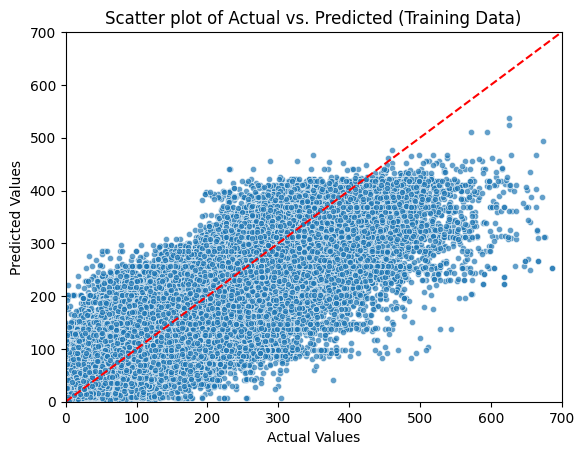

In [ ]:
y_actual = y_train

plt.scatter(y_actual, y_pred_train, s=20, alpha=0.7, edgecolors='w', linewidth=0.5)

# Plot the 45-degree line
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')

# Set axis labels
plt.xlim(0,700)
plt.ylim(0,700)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Set plot title
plt.title('Scatter plot of Actual vs. Predicted (Training Data)')

# Show the plot
plt.show()

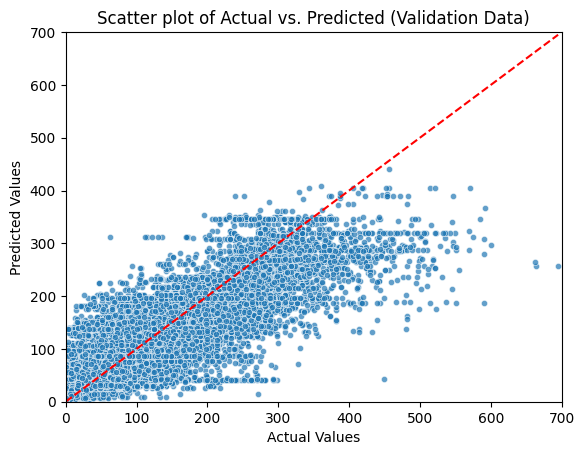

In [ ]:
# Plot the scatter plot of Actual vs. Predicted (Validation Data)

y_actual = y_test
plt.scatter(y_actual, y_pred, s=20, alpha=0.7, edgecolors='w', linewidth=0.5)

# Plot the 45-degree line
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')

# Set axis labels
plt.xlim(0,700)
plt.ylim(0,700)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Set plot title
plt.title('Scatter plot of Actual vs. Predicted (Validation Data)')

# Show the plot
plt.show()

## 4. Uploading trained model to Google Earth Engine:
1. Serialise the random forest model to a list of strings (where each string represents a decision tree)
2. Convert the list of strings to a `ee.FeatureCollection`
3. Export the `ee.FeatureCollection` to Google Earth Engine as an asset

Serialise random forest to strings and store it in rf_strings

In [ ]:

rf_strings = ml.rf_to_strings(rf_model, feature_names, output_mode='regression', processes=6)


To convert the list of strings to a ee.FeatureCollection :
1. Convert the list of strings to a list of dummy ee.Features (with any ~NON NULL~ geometry and property `tree` set as the string representing the tree)
2. Convert this list of features to a ee.FeatureCollections and store it in fc_string

In [ ]:
dummy_feature = ee.Feature(ee.Geometry.Point([-114.318, 38.985]));
treeStrings = []
for dt in rf_strings:
  feat = dummy_feature.set('tree', dt)
  treeStrings.append(feat)
fc_string = ee.FeatureCollection(treeStrings)

Export the `ee.FeatureCollection` to earth engine asset

In [ ]:
asset_name = '''Name of the asset for Random Forest model'''
task_name = asset_name+'_task'
asset_path= '''Path of the asset for Random Forest model'''
task = ee.batch.Export.table.toAsset(fc_string,task_name,asset_path);
task.start()

## 5. Downloading the Model in GEE and using it to inference ET:
To download the model from GEE asset and load it as a classifier use this code snippet in Google Earth Engine Editor:
```
var RandomForestasFeatCollection = ee.FeatureCollection(assetName).aggregate_array('tree').aside(print);
var classifier = ee.Classifier.decisionTreeEnsemble(RandomForestasFeatCollection);
```
Replace assetName with the path of asset that contains the model. The code is available in the script at: `Vatsal_Stiti/FinalPipelineScripts/InferenceETFromModelAsset`. Use this script to predict ET of any area on a given date.